<a href="https://colab.research.google.com/github/abdoulayegk/2nd-Place-Solution-Data-Science-week-Guinea-Hackathon/blob/main/Tanzania_Tourism_Classification_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install git+https://github.com/eaedk/testing-zindi-package.git

from zindi.user import Zindian

#@title Input Username

# Login info for a Zindi Account

USERNAME = "Abdoulayegk" #@param {type : "string"}

# object
user = Zindian(username=USERNAME) # Sign in  

Your password
>> ··········

[ 🟢 ] 👋🏾👋🏾 Welcome Abdoulayegk 👋🏾👋🏾



In [ ]:
user.select_a_challenge(reward='all', kind='competition', active='true')                               # Select a Zindi challenge

__________________________________________________________________________________________________________________________________
|     |              |                  |                    |          
|index|  challenge   |     problem      |       reward       |    id    
|     |              |                  |                    |          
----------------------------------------------------------------------------------------------------------------------------------
|  0  |Public Compet |  Classification  |     $1 000 USD     | datafest-africa-2022...
----------------------------------------------------------------------------------------------------------------------------------
|  1  |Public Compet |    Prediction    |      $300 USD      | zindi-weekendz-layerai-air-quality-prediction-chal...
----------------------------------------------------------------------------------------------------------------------------------
|  2  |Public Compet |    Prediction    | 1 000 Zindi

In [ ]:
user.download_dataset(destination="dataset") # Download the dataset of the selected challenge

dataset/VariableDefinitions.csv: 100%|██████████| 1.22k/1.22k [00:00<00:00, 753ko/s]
dataset/SampleSubmission.csv: 100%|██████████| 133k/133k [00:00<00:00, 589ko/s] 
dataset/Test.csv: 100%|██████████| 956k/956k [00:00<00:00, 2.52Mo/s]
dataset/Train.csv: 100%|██████████| 3.00M/3.00M [00:00<00:00, 5.66Mo/s]
dataset/ai4d-lab-tanzania-tourism-classification-challenge.zip: 100%|██████████| 472k/472k [00:00<00:00, 1.53Mo/s]


In [ ]:
!pip install -q catboost

     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
!pip install -q category-encoders

     |████████████████████████████████| 69 kB 7.0 MB/s 


In [ ]:
import random
import warnings

import category_encoders as ce
import matplotlib.pyplot as plt
import missingno as mn
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier

from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from xgboost import XGBClassifier

plt.style.use('ggplot')

SEED= 42
np.random.seed(SEED)
random.seed(SEED)
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
train = pd.read_csv('dataset/Train.csv')
test = pd.read_csv('dataset/Test.csv')
ss = pd.read_csv('dataset/SampleSubmission.csv')

In [ ]:
train.head()

,Tour_ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,first_trip_tz,cost_category
0,tour_id1hffseyw,ITALY,45-64,With Children,0.0,2.0,Visiting Friends and Relatives,Beach Tourism,"Friends, relatives",Package Tour,...,Yes,Yes,Yes,No,No,No,0,7,Yes,High Cost
1,tour_idnacd7zag,UNITED KINGDOM,25-44,With Spouse,1.0,1.0,Leisure and Holidays,Wildlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,Yes,Yes,No,No,No,0,7,Yes,High Cost
2,tour_id62vz7e71,UNITED STATES OF AMERICA,65+,With Spouse,1.0,1.0,Leisure and Holidays,Widlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,Yes,Yes,Yes,Yes,No,6,6,Yes,Higher Cost
3,tour_idrc76tzix,RWANDA,25-44,With Spouse and Children,3.0,1.0,Leisure and Holidays,Beach Tourism,"Radio, TV, Web",Independent,...,No,No,No,No,No,No,3,0,No,Lower Cost
4,tour_idn723m0n9,UNITED STATES OF AMERICA,45-64,Alone,0.0,1.0,Leisure and Holidays,Widlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,Yes,Yes,No,Yes,Yes,7,0,Yes,Higher Cost


In [ ]:
test.head()

,Tour_ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,package_transport_int,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,first_trip_tz
0,tour_idynufedne,KOREA,25-44,Alone,0.0,1.0,Leisure and Holidays,Widlife Tourism,Others,Independent,No,No,No,No,No,No,No,7,4,Yes
1,tour_id9r3y5moe,UNITED KINGDOM,45-64,With Children,1.0,1.0,Leisure and Holidays,Conference Tourism,"Travel agent, tour operator",Package Tour,Yes,Yes,Yes,Yes,Yes,Yes,Yes,7,0,Yes
2,tour_idf6itml6g,ITALY,25-44,With Spouse,1.0,1.0,Leisure and Holidays,Beach Tourism,"Travel agent, tour operator",Package Tour,Yes,Yes,No,Yes,No,No,No,0,6,Yes
3,tour_id99u4znru,KENYA,25-44,Alone,0.0,1.0,Other,Beach Tourism,"Radio, TV, Web",Independent,No,No,No,No,No,No,No,3,4,No
4,tour_idj4i9urbx,ZAMBIA,25-44,Alone,0.0,1.0,Business,Widlife Tourism,"Radio, TV, Web",Independent,No,No,No,No,No,No,No,6,0,No


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18506 entries, 0 to 18505
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Tour_ID                18506 non-null  object 
 1   country                18506 non-null  object 
 2   age_group              18506 non-null  object 
 3   travel_with            17431 non-null  object 
 4   total_female           18504 non-null  float64
 5   total_male             18500 non-null  float64
 6   purpose                18506 non-null  object 
 7   main_activity          18506 non-null  object 
 8   info_source            18506 non-null  object 
 9   tour_arrangement       18506 non-null  object 
 10  package_transport_int  18506 non-null  object 
 11  package_accomodation   18506 non-null  object 
 12  package_food           18506 non-null  object 
 13  package_transport_tz   18506 non-null  object 
 14  package_sightseeing    18506 non-null  object 
 15  pa

In [ ]:
ss.head()

,Tour_ID,High Cost,Higher Cost,Highest Cost,Low Cost,Lower Cost,Normal Cost
0,tour_idynufedne,0.23,0.56,0.04,0.12,0.005,0.12
1,tour_id9r3y5moe,NaN,NaN,NaN,NaN,NaN,NaN
2,tour_idf6itml6g,NaN,NaN,NaN,NaN,NaN,NaN
3,tour_id99u4znru,NaN,NaN,NaN,NaN,NaN,NaN
4,tour_idj4i9urbx,NaN,NaN,NaN,NaN,NaN,NaN


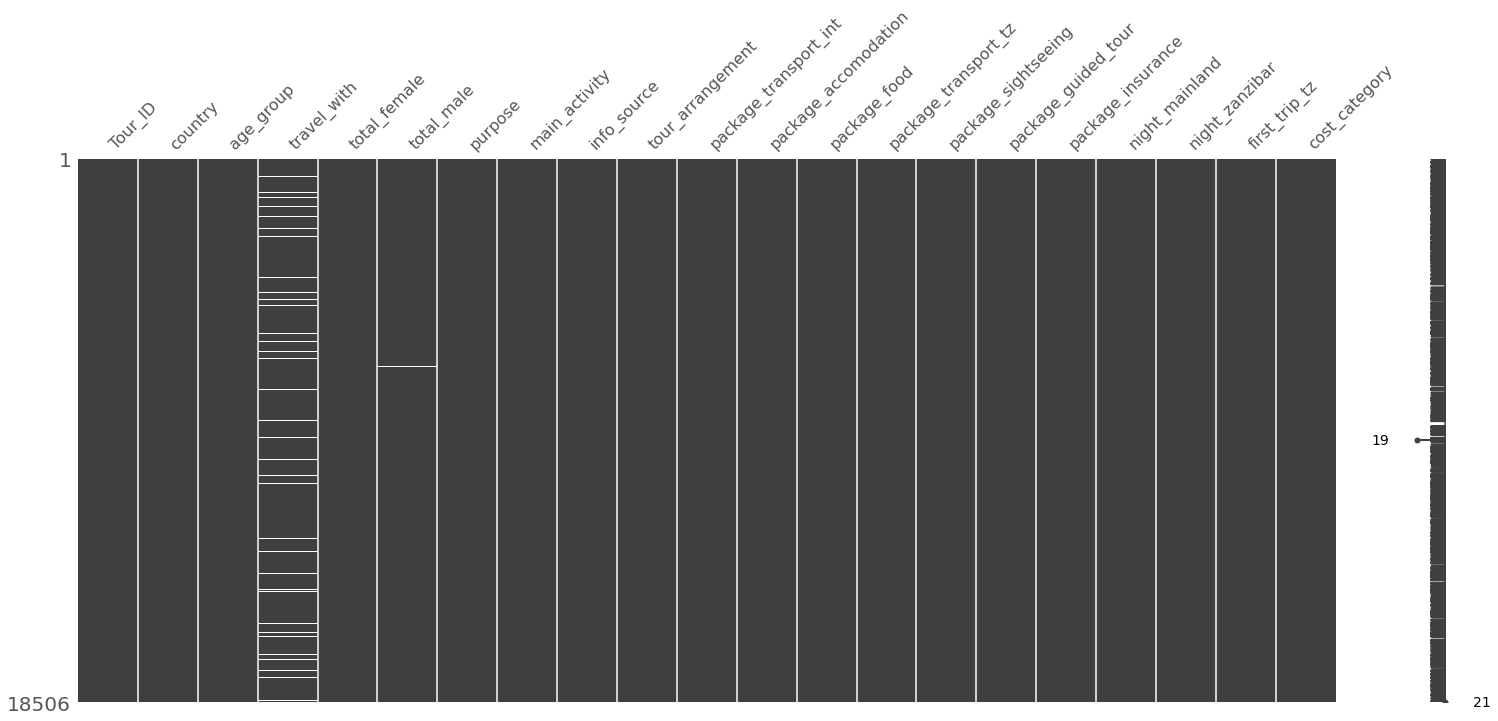

In [ ]:
mn.matrix(train)

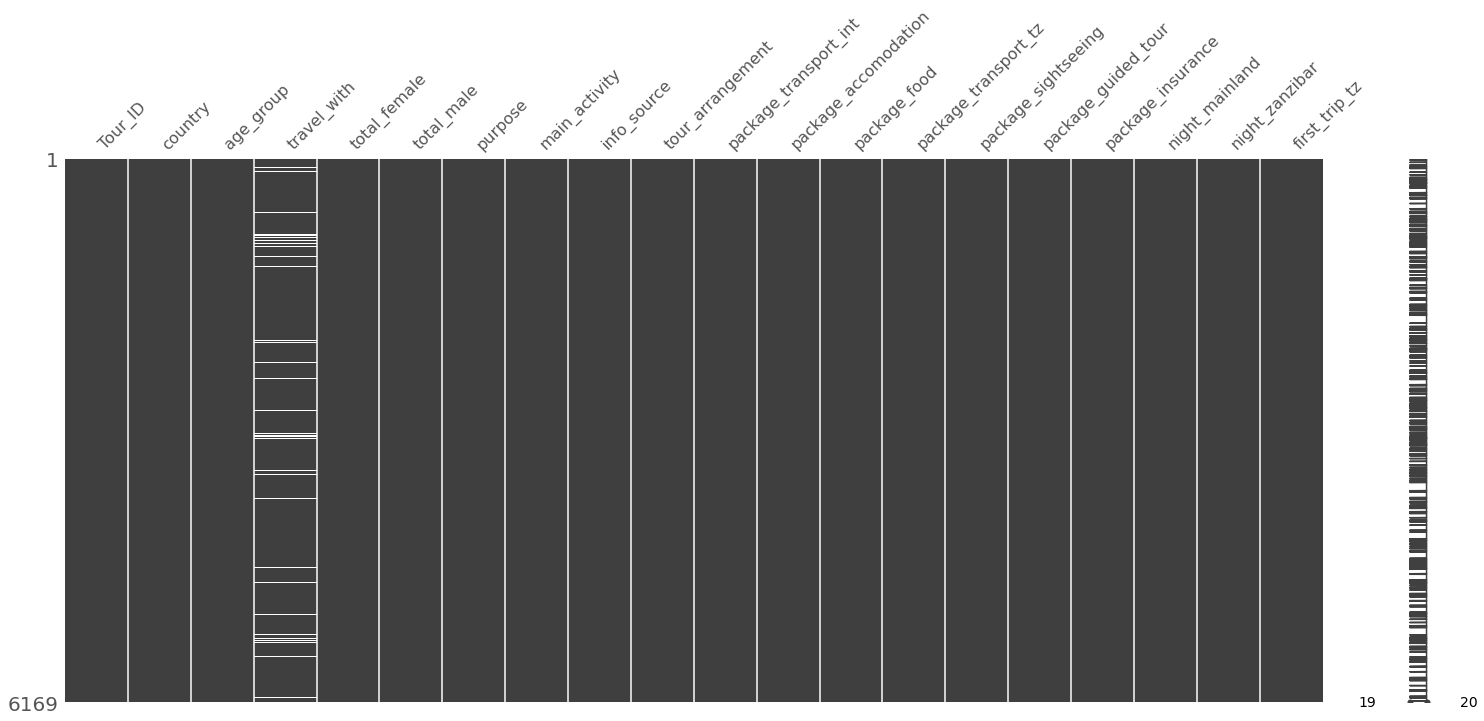

In [ ]:
mn.matrix(test)

In [ ]:
train.shape, test.shape

((18506, 21), (6169, 20))

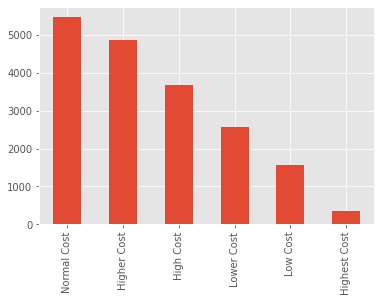

In [ ]:
train.cost_category.value_counts().plot(kind='bar')
plt.show()

In [ ]:
test.head()

,Tour_ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,package_transport_int,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,first_trip_tz
0,tour_idynufedne,KOREA,25-44,Alone,0.0,1.0,Leisure and Holidays,Widlife Tourism,Others,Independent,No,No,No,No,No,No,No,7,4,Yes
1,tour_id9r3y5moe,UNITED KINGDOM,45-64,With Children,1.0,1.0,Leisure and Holidays,Conference Tourism,"Travel agent, tour operator",Package Tour,Yes,Yes,Yes,Yes,Yes,Yes,Yes,7,0,Yes
2,tour_idf6itml6g,ITALY,25-44,With Spouse,1.0,1.0,Leisure and Holidays,Beach Tourism,"Travel agent, tour operator",Package Tour,Yes,Yes,No,Yes,No,No,No,0,6,Yes
3,tour_id99u4znru,KENYA,25-44,Alone,0.0,1.0,Other,Beach Tourism,"Radio, TV, Web",Independent,No,No,No,No,No,No,No,3,4,No
4,tour_idj4i9urbx,ZAMBIA,25-44,Alone,0.0,1.0,Business,Widlife Tourism,"Radio, TV, Web",Independent,No,No,No,No,No,No,No,6,0,No


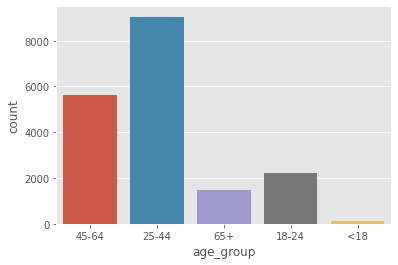

In [ ]:
sns.countplot(train.age_group)

In [ ]:
def age_group_to_category(age):
    if (age == '<18'):
        return 'Teenager'
    elif (age == '18-24'):
        return 'Youth'
    elif (age == '24-44'):
        return 'Adult'
    elif(age == '45-64'):
        return 'Middle_age'
    else:
        return 'Senior_citizens'

train['age_category'] = train['age_group'].apply(age_group_to_category)
test['age_category'] = test['age_group'].apply(age_group_to_category)
train.head()

,Tour_ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,first_trip_tz,cost_category,age_category
0,tour_id1hffseyw,ITALY,45-64,With Children,0.0,2.0,Visiting Friends and Relatives,Beach Tourism,"Friends, relatives",Package Tour,...,Yes,Yes,No,No,No,0,7,Yes,High Cost,Middle_age
1,tour_idnacd7zag,UNITED KINGDOM,25-44,With Spouse,1.0,1.0,Leisure and Holidays,Wildlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,Yes,No,No,No,0,7,Yes,High Cost,Senior_citizens
2,tour_id62vz7e71,UNITED STATES OF AMERICA,65+,With Spouse,1.0,1.0,Leisure and Holidays,Widlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,Yes,Yes,Yes,No,6,6,Yes,Higher Cost,Senior_citizens
3,tour_idrc76tzix,RWANDA,25-44,With Spouse and Children,3.0,1.0,Leisure and Holidays,Beach Tourism,"Radio, TV, Web",Independent,...,No,No,No,No,No,3,0,No,Lower Cost,Senior_citizens
4,tour_idn723m0n9,UNITED STATES OF AMERICA,45-64,Alone,0.0,1.0,Leisure and Holidays,Widlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,Yes,No,Yes,Yes,7,0,Yes,Higher Cost,Middle_age


In [ ]:
train.package_food.value_counts()

No     10143
Yes     8363
Name: package_food, dtype: int64

In [ ]:
def feature_engineering(df):
    df['total_group_of_people'] = df['total_female']+df['total_male']
    df['total_nights'] =df['night_zanzibar']+df['night_mainland']
 
   # df['mean_gender'] = df.groupby(['total_male', 'total_female']).transform(lambda x: x.mean()).total_group
    
    return df

train = feature_engineering(train)
test = feature_engineering(test)

In [ ]:
train.country.nunique()

131

In [ ]:
test.country.nunique()

118

In [ ]:
def dist_box(data):
 # function plots a combined graph for univariate analysis of continous variable 
 #to check spread, central tendency , dispersion and outliers  
    Name=data.name.upper()
    fig,(ax_box,ax_dis)  =plt.subplots(nrows=2,sharex=True,gridspec_kw = {"height_ratios": (.25, .75)},figsize=(8, 5))
    mean=data.mean()
    median=data.median()
    mode=data.mode().tolist()[0]
    sns.set_theme(style="white")
    fig.suptitle("SPREAD OF DATA FOR "+ Name  , fontsize=18, fontweight='bold')
    sns.boxplot(x=data,showmeans=True, orient='h',color="teal",ax=ax_box)
    ax_box.set(xlabel='')
     # just trying to make visualisation better. This will set background to white
    sns.despine(top=True,right=True,left=True) # to remove side line from graph
    sns.distplot(data,kde=False,color='purple',ax=ax_dis)
    ax_dis.axvline(mean, color='r', linestyle='--',linewidth=2)
    ax_dis.axvline(median, color='g', linestyle='-',linewidth=2)
    ax_dis.axvline(mode, color='y', linestyle='-',linewidth=2)
    plt.legend({'Mean':mean,'Median':median,'Mode':mode})

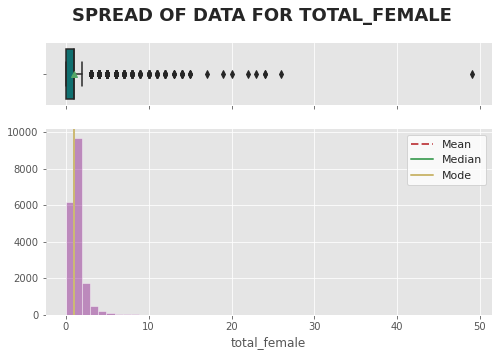

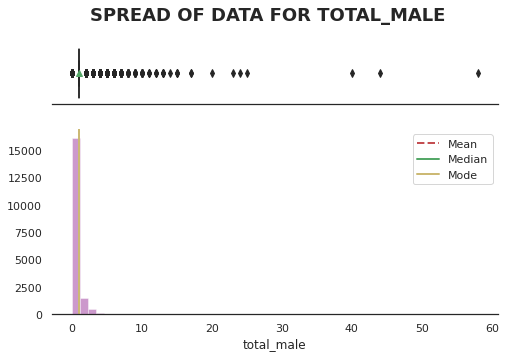

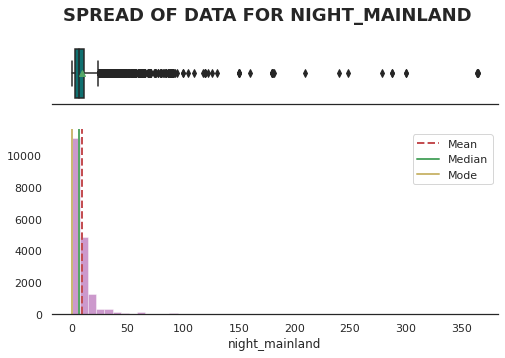

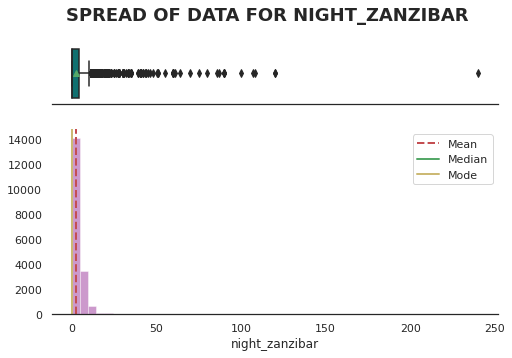

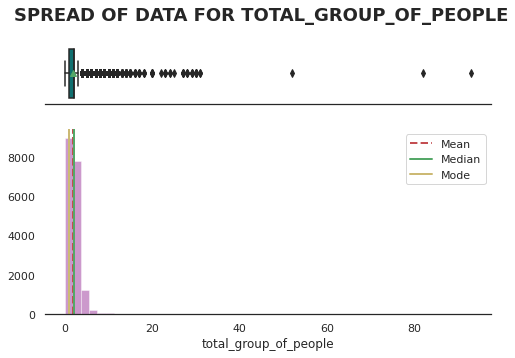

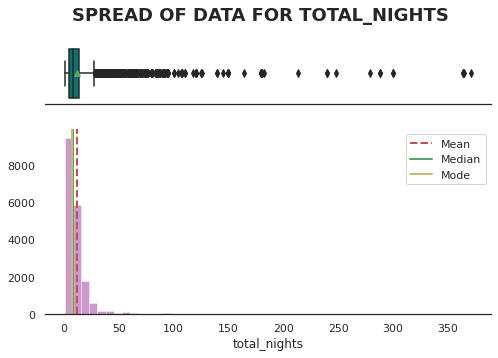

In [ ]:
list_col=  train.select_dtypes(include='number').columns.to_list()
for i in range(len(list_col)):
    dist_box(train[list_col[i]])

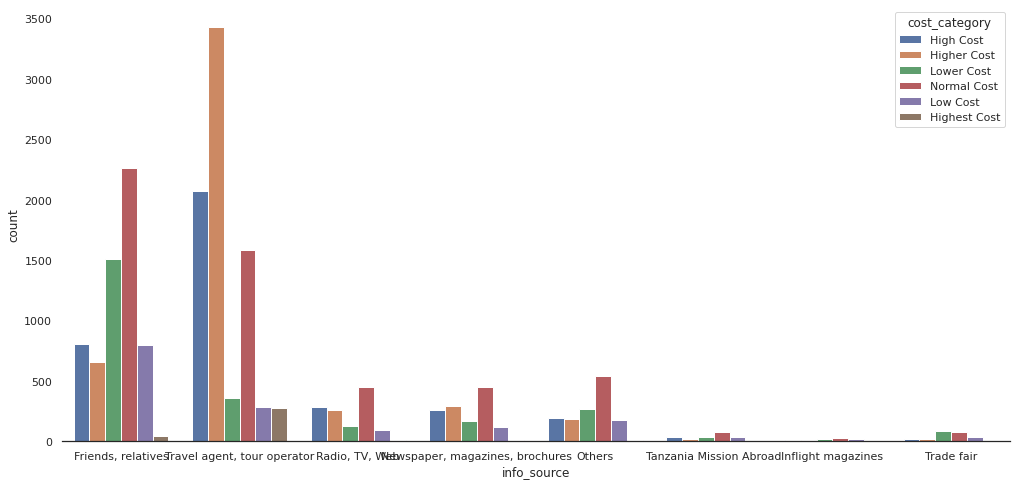

In [ ]:
plt.figure(figsize=(17,8))
sns.countplot(x="info_source", data=train,  hue="cost_category")
sns.despine(top=True,right=True,left=True) # to remove side line from graph

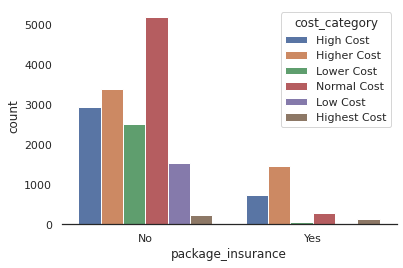

In [ ]:
sns.countplot(x="package_insurance", data=train,  hue="cost_category")
sns.despine(top=True,right=True,left=True) # to remove side line from graph

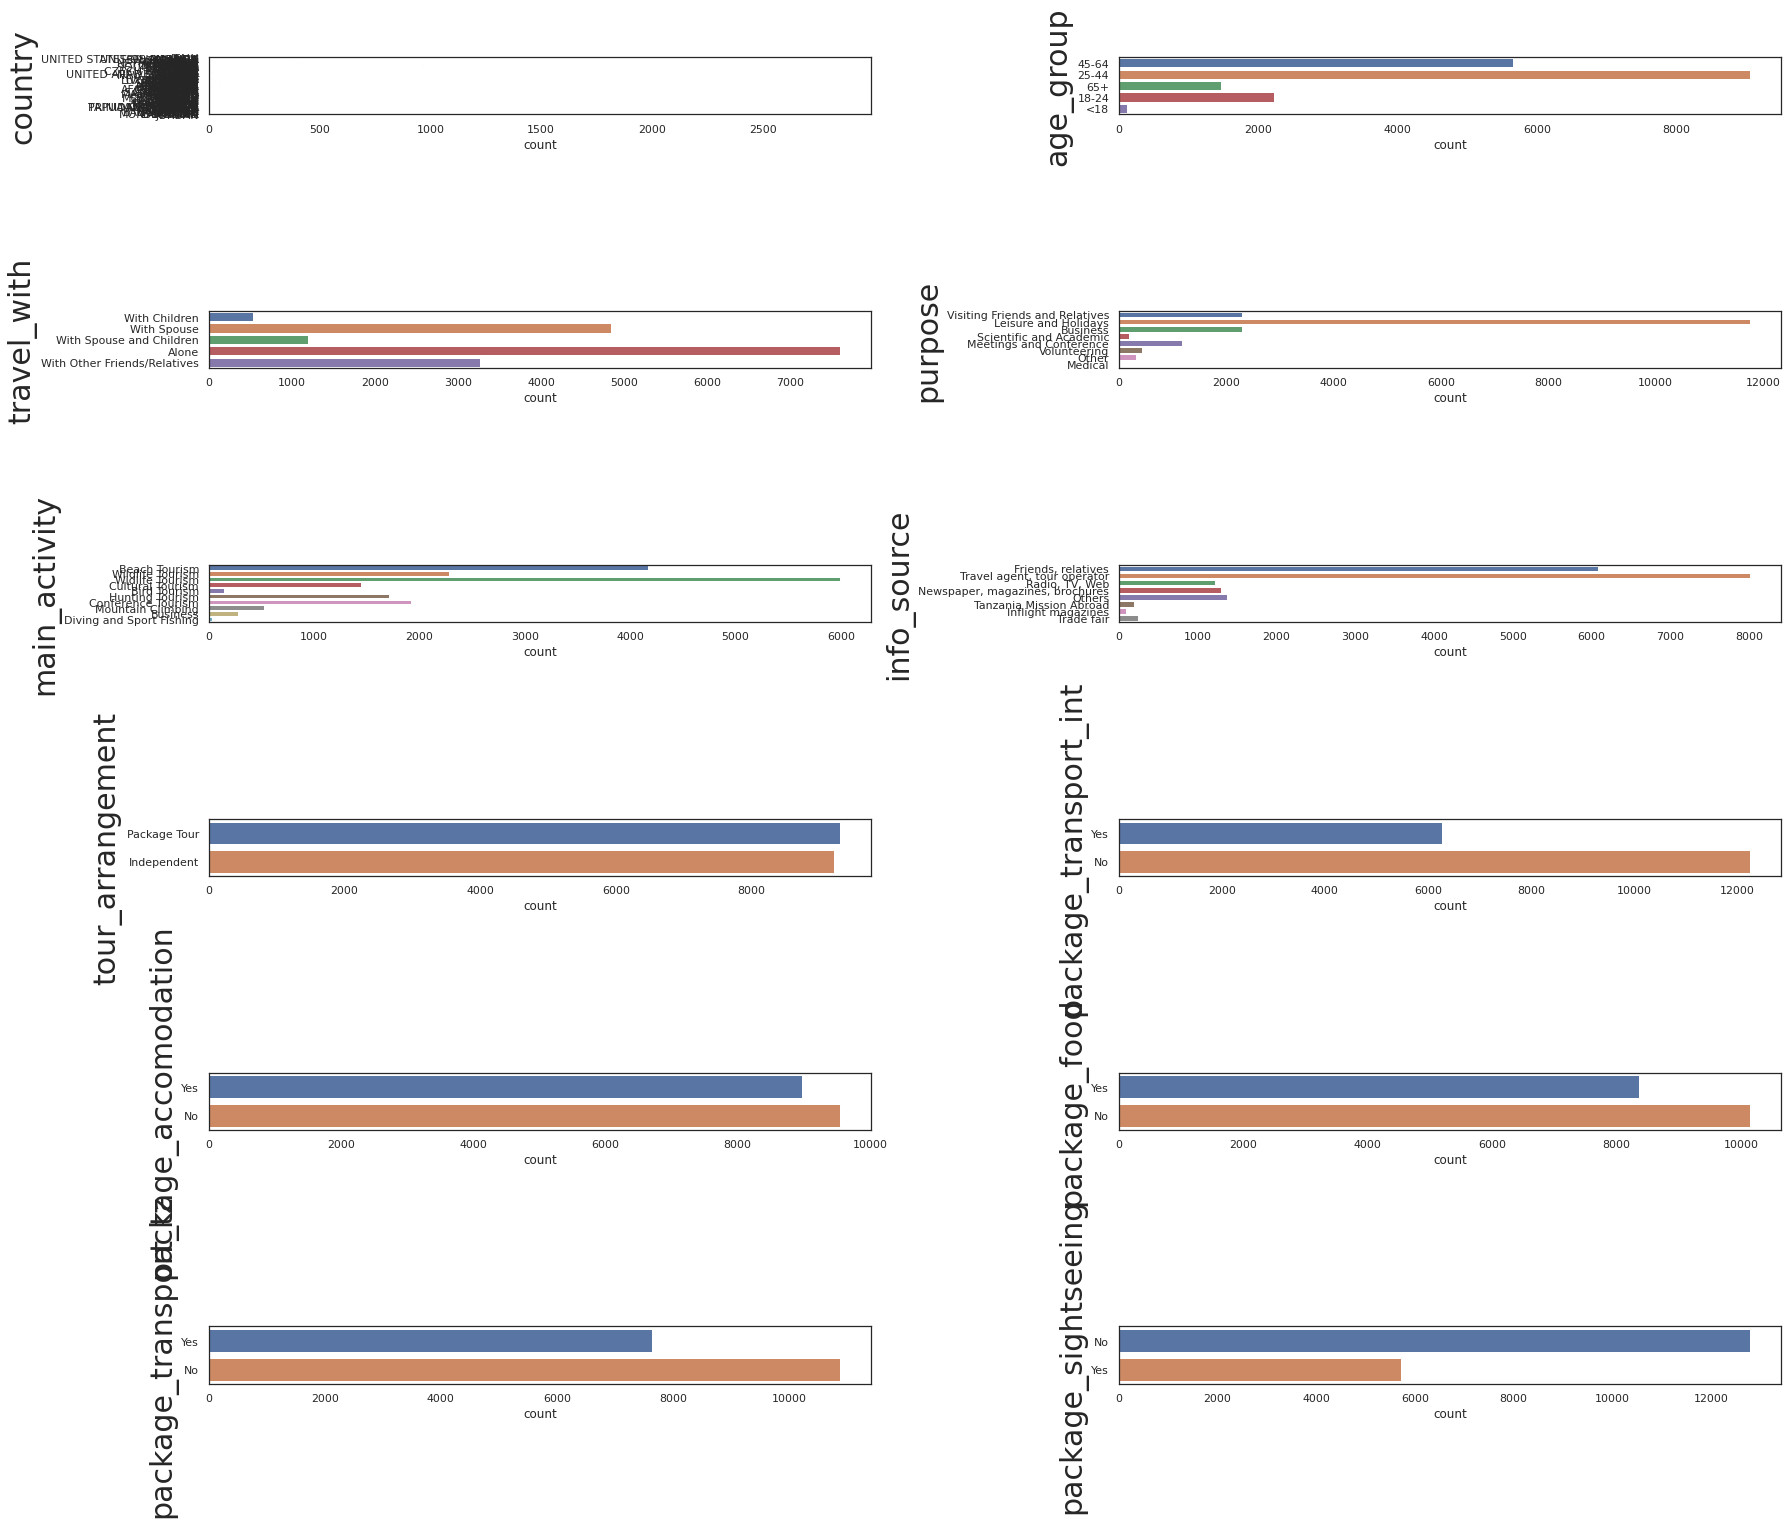

In [ ]:
df_categoric_features = train.select_dtypes(include='object').drop(['Tour_ID'], axis=1)
fig, ax = plt.subplots(6, 2, figsize=(25, 20))
for variable, subplot in zip(df_categoric_features, ax.flatten()):
    countplot = sns.countplot(y=train[variable], ax=subplot )
    countplot.set_ylabel(variable, fontsize = 30)
plt.tight_layout()   
plt.show()

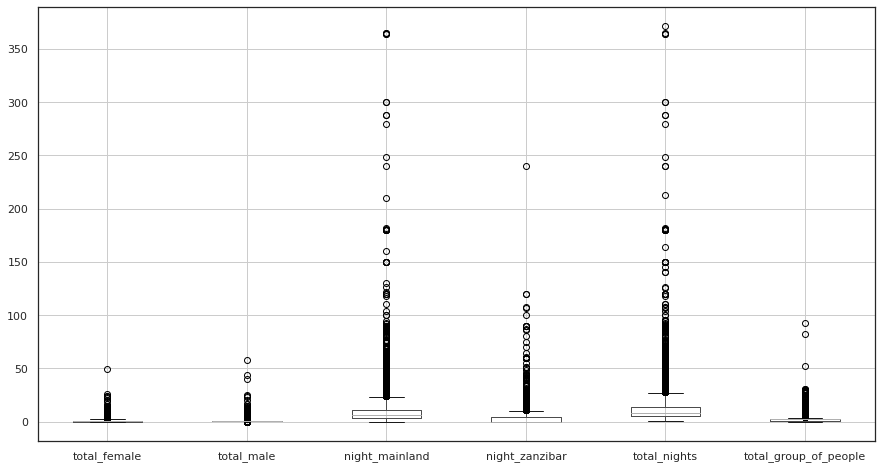

In [ ]:
plt.rcParams['figure.figsize']=(15,8)
train.boxplot(column=['total_female', 'total_male','night_mainland', 'night_zanzibar', 'total_nights', 'total_group_of_people'])
plt.show()

In [ ]:
le = LabelEncoder()

# Encoding the country column
train['country'] = le.fit_transform(train['country'])
test['country'] = le.fit_transform(test['country'])

In [ ]:
train = pd.get_dummies(train, columns=["travel_with","main_activity", "info_source","purpose"])#attempting for country name

In [ ]:
test = pd.get_dummies(test, columns=["travel_with","main_activity", "info_source","purpose"])#attempting for country name

In [ ]:
encode_col = ["package_transport_int","package_accomodation","package_food","package_transport_tz","package_sightseeing",
 "tour_arrangement", "package_guided_tour", "package_insurance", "first_trip_tz"]

In [ ]:
train['cost_category'].value_counts()

Normal Cost     5471
Higher Cost     4865
High Cost       3678
Lower Cost      2567
Low Cost        1566
Highest Cost     359
Name: cost_category, dtype: int64

In [ ]:


train['cost_category'] = le.fit_transform(train['cost_category'])

train['cost_category'].value_counts()

5    5471
1    4865
0    3678
4    2567
3    1566
2     359
Name: cost_category, dtype: int64

In [ ]:
le.classes_

array(['High Cost', 'Higher Cost', 'Highest Cost', 'Low Cost',
       'Lower Cost', 'Normal Cost'], dtype=object)

In [ ]:
#train['travel_with'].fillna(train['travel_with'].mode()[0], inplace=True)
train['total_female'].fillna(train['total_female'].mode()[0], inplace=True)
train['total_male'].fillna(train['total_male'].mode()[0], inplace=True)
train['total_group_of_people'].fillna(train['total_group_of_people'].mode()[0], inplace=True)

In [ ]:
#test['travel_with'].fillna(test['travel_with'].mode()[0], inplace=True)
test['total_female'].fillna(test['total_female'].mode()[0], inplace=True)
test['total_male'].fillna(test['total_male'].mode()[0], inplace=True)
test['total_group_of_people'].fillna(test['total_group_of_people'].mode()[0], inplace=True)

In [ ]:
X = train.drop(['Tour_ID','age_group','cost_category'],axis=1)
y = train.cost_category
test = test.drop(['Tour_ID','age_group'],axis=1)

Here I am capturing NaN per row and making new feature.
I am doing this because sometime missing carry signal so we only give it to the model.

In [ ]:
def feature_engineering(df):
    # df['NaN_row'] = df.isna().sum(axis=1)
    df['std'] = df.std(axis=1)
    return df

X = feature_engineering(X)
test = feature_engineering(test)

In [ ]:
X.head()

,country,total_female,total_male,tour_arrangement,package_transport_int,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,...,"info_source_Travel agent, tour operator",purpose_Business,purpose_Leisure and Holidays,purpose_Medical,purpose_Meetings and Conference,purpose_Other,purpose_Scientific and Academic,purpose_Visiting Friends and Relatives,purpose_Volunteering,std
0,54,0.0,2.0,Package Tour,Yes,Yes,Yes,Yes,No,No,...,0,0,0,0,0,0,0,1,0,8.813380
1,123,1.0,1.0,Package Tour,Yes,Yes,Yes,Yes,No,No,...,1,0,1,0,0,0,0,0,0,19.921271
2,124,1.0,1.0,Package Tour,Yes,Yes,Yes,Yes,Yes,Yes,...,1,0,1,0,0,0,0,0,0,20.108879
3,96,3.0,1.0,Independent,No,No,No,No,No,No,...,0,0,1,0,0,0,0,0,0,15.528526
4,124,0.0,1.0,Package Tour,Yes,Yes,Yes,Yes,No,Yes,...,1,0,1,0,0,0,0,0,0,20.090549


In [ ]:
# X['n_country_gender'] = X.groupby('country')['total_group_of_people'].transform('nunique')
# X['n_package_accomodation_per_country'] = X.groupby('package_accomodation')['country'].transform('nunique')
# X['n_package_insurance_country'] = X.groupby('package_insurance')['country'].transform('nunique')
# X['n_source_info_country'] = X.groupby('info_source')['country'].transform('nunique')

In [ ]:
# X.head()

In [ ]:
# we are going to do the same thing on the test set as well.

# test['n_country_gender'] = test.groupby('country')['total_group_of_people'].transform('nunique')
# test['n_package_accomodation_per_country'] = test.groupby('package_accomodation')['country'].transform('nunique')
# test['n_package_insurance_country'] = test.groupby('package_insurance')['country'].transform('nunique')
# test['n_source_info_country'] = test.groupby('info_source')['country'].transform('nunique')

In [ ]:
X.shape, test.shape

((18506, 49), (6169, 49))

#### Pipeline for data transformation

Here I am going to try ordinal encoding because most of the features are in order.


In [ ]:
ordinal_enc = ce.OrdinalEncoder(cols=[ 
                                  'tour_arrangement', 
                                  'package_transport_int', 'package_accomodation', 
                                  'package_food', 'package_transport_tz', 'package_sightseeing', 
                                  'package_guided_tour', 'package_insurance', 
                                  'first_trip_tz', 'age_category'])
X = ordinal_enc.fit_transform(X)
test = ordinal_enc.transform(test)
X.head()

,country,total_female,total_male,tour_arrangement,package_transport_int,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,...,"info_source_Travel agent, tour operator",purpose_Business,purpose_Leisure and Holidays,purpose_Medical,purpose_Meetings and Conference,purpose_Other,purpose_Scientific and Academic,purpose_Visiting Friends and Relatives,purpose_Volunteering,std
0,54,0.0,2.0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,1,0,8.813380
1,123,1.0,1.0,1,1,1,1,1,1,1,...,1,0,1,0,0,0,0,0,0,19.921271
2,124,1.0,1.0,1,1,1,1,1,2,2,...,1,0,1,0,0,0,0,0,0,20.108879
3,96,3.0,1.0,2,2,2,2,2,1,1,...,0,0,1,0,0,0,0,0,0,15.528526
4,124,0.0,1.0,1,1,1,1,1,1,2,...,1,0,1,0,0,0,0,0,0,20.090549


In [ ]:
for col_name in X.columns:
    X[col_name]= X[col_name].astype('float')

X.dtypes

country                                        float64
total_female                                   float64
total_male                                     float64
tour_arrangement                               float64
package_transport_int                          float64
package_accomodation                           float64
package_food                                   float64
package_transport_tz                           float64
package_sightseeing                            float64
package_guided_tour                            float64
package_insurance                              float64
night_mainland                                 float64
night_zanzibar                                 float64
first_trip_tz                                  float64
age_category                                   float64
total_group_of_people                          float64
total_nights                                   float64
travel_with_Alone                              float64
travel_wit

In [ ]:
for col_name in X.columns:
    test[col_name]= test[col_name].astype('float')

X.dtypes

country                                        float64
total_female                                   float64
total_male                                     float64
tour_arrangement                               float64
package_transport_int                          float64
package_accomodation                           float64
package_food                                   float64
package_transport_tz                           float64
package_sightseeing                            float64
package_guided_tour                            float64
package_insurance                              float64
night_mainland                                 float64
night_zanzibar                                 float64
first_trip_tz                                  float64
age_category                                   float64
total_group_of_people                          float64
total_nights                                   float64
travel_with_Alone                              float64
travel_wit

In [ ]:
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# test = scaler.transform(test)

## LghtGBM

In [ ]:

err1=[]

fold=KFold(n_splits=10, random_state=42, shuffle=True)
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    m2 = LGBMClassifier(n_estimators=1000,random_state=SEED)
    m2.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)],verbose=100,)
    preds = m2.predict_proba(X_test)
    print("err: ",(log_loss(y_test,preds)))
    err1.append((log_loss(y_test,preds)))
    p3 = m2.predict_proba(test)
print("The average log loss is:", np.mean(err1))

[100]	training's multi_logloss: 0.867445	valid_1's multi_logloss: 1.08428
[200]	training's multi_logloss: 0.749141	valid_1's multi_logloss: 1.09505
[300]	training's multi_logloss: 0.666109	valid_1's multi_logloss: 1.11058
[400]	training's multi_logloss: 0.59951	valid_1's multi_logloss: 1.13476
[500]	training's multi_logloss: 0.542222	valid_1's multi_logloss: 1.15646
[600]	training's multi_logloss: 0.493429	valid_1's multi_logloss: 1.17951
[700]	training's multi_logloss: 0.450958	valid_1's multi_logloss: 1.19988
[800]	training's multi_logloss: 0.416094	valid_1's multi_logloss: 1.22181
[900]	training's multi_logloss: 0.382912	valid_1's multi_logloss: 1.24557
[1000]	training's multi_logloss: 0.354639	valid_1's multi_logloss: 1.27257
err:  1.2725671495252504
[100]	training's multi_logloss: 0.86779	valid_1's multi_logloss: 1.07274
[200]	training's multi_logloss: 0.747321	valid_1's multi_logloss: 1.08757
[300]	training's multi_logloss: 0.66209	valid_1's multi_logloss: 1.10645
[400]	training'

In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
# train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=100)
# train_set = lgb.Dataset(train_X, train_y)
# valid_set = lgb.Dataset(test_X, test_y)
# params = {
#         #"objective" : "MultiClass",
#         "metric" : "auc"}
# model = lgb.train(
#         params = params,
#         train_set = train_set,
#         valid_sets = [train_set, valid_set],
#         num_boost_round = 1000)
    
# pred_test = model.predict(test_X)
# score = accuracy_score(test_y, pred_test)
# print(score)

In [ ]:
# ids = ss.Tour_ID

# subfile = pd.DataFrame({
#     'Tour_ID':ss.Tour_ID,
# })
# subfile = pd.DataFrame(data=p3, columns = le.classes_)
# subfile['Tour_ID'] = ids

# subfile.set_index('Tour_ID').to_csv('lgb.csv')

## Catboost

## Using stratifiedKfold

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
err1=[]

fold=StratifiedKFold(n_splits=10, random_state=SEED,shuffle=True)
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    m2 = CatBoostClassifier(random_state=SEED,  n_estimators=5000, 
                            loss_function='MultiClass', early_stopping_rounds = 200,
                            bootstrap_type='Bayesian',use_best_model=True,
                            learning_rate=0.01,task_type='GPU')
    m2.fit(X_train,y_train,eval_set=(X_test, y_test),early_stopping_rounds = 50,verbose=100,)
    preds = m2.predict_proba(X_test)
    print("err: ",(log_loss(y_test,preds)))
    err1.append((log_loss(y_test,preds)))
    p2 = m2.predict_proba(test)
print("The average score of Catboost is: ",np.mean(err1))

0:	learn: 1.7797642	test: 1.7796042	best: 1.7796042 (0)	total: 13.8ms	remaining: 1m 9s
100:	learn: 1.2829675	test: 1.2834776	best: 1.2834776 (100)	total: 942ms	remaining: 45.7s
200:	learn: 1.1633911	test: 1.1660495	best: 1.1660495 (200)	total: 1.71s	remaining: 40.8s
300:	learn: 1.1171143	test: 1.1220405	best: 1.1220405 (300)	total: 2.44s	remaining: 38s
400:	learn: 1.0929377	test: 1.1011545	best: 1.1011545 (400)	total: 3.15s	remaining: 36.2s
500:	learn: 1.0768842	test: 1.0883730	best: 1.0883730 (500)	total: 3.89s	remaining: 34.9s
600:	learn: 1.0650330	test: 1.0802391	best: 1.0802391 (600)	total: 4.61s	remaining: 33.8s
700:	learn: 1.0551233	test: 1.0746503	best: 1.0746503 (700)	total: 5.35s	remaining: 32.8s
800:	learn: 1.0466804	test: 1.0704445	best: 1.0704445 (800)	total: 6.09s	remaining: 31.9s
900:	learn: 1.0391690	test: 1.0666930	best: 1.0666930 (900)	total: 6.82s	remaining: 31s
1000:	learn: 1.0324406	test: 1.0636386	best: 1.0636326 (999)	total: 7.55s	remaining: 30.2s
1100:	learn: 1.0

In [ ]:
# map_target
ID = ss.Tour_ID

In [ ]:
subfile = pd.DataFrame({
    'Tour_ID':ss.Tour_ID,
})
subfile = pd.DataFrame(data=p2, columns = le.classes_)
subfile['Tour_ID'] = ID

subfile.set_index('Tour_ID').to_csv('sub1.csv')

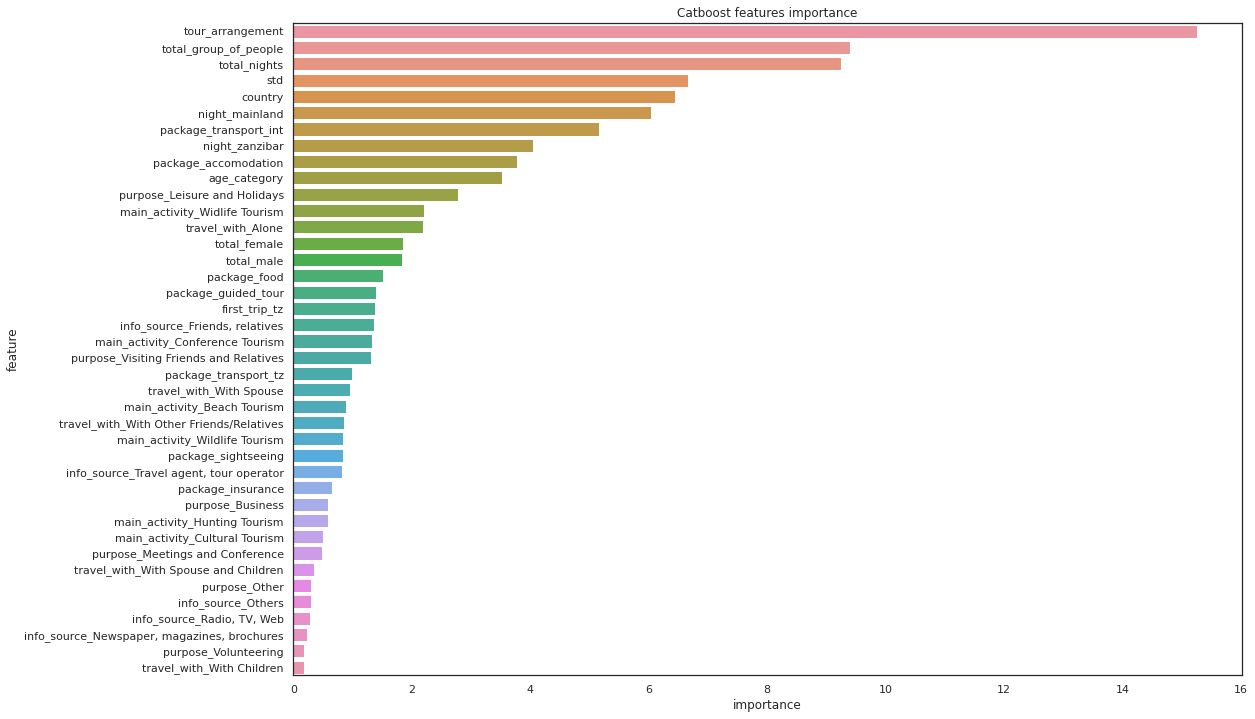

In [ ]:
feature_importance_df = pd.DataFrame(m2.feature_importances_, columns=["importance"])
feature_importance_df["feature"] = X.columns

plt.figure(figsize=(17, 12))
sns.barplot(
    x="importance",
    y="feature",
    data=feature_importance_df.sort_values(by=["importance"], ascending=False).head(40),
)
plt.title("Catboost features importance");